# House price advanced regression

## Problem statement
To predict house prices for samples provided in test.csv file using advanced regression techniques.

## Datasets
- train.csv Contains House sales samples (1460 sample) with 79 variables including SalePrice which is the dependent variable
- test.csv  Contains House sales samples (1460 sample) without SalePrice which is the variable we should predict
- data_description.txt full description of each variable

## Evaluation
- Goal

Predicting sale price for each sample (house) in test data. For each Id in the test set, we must predict the value of the SalePrice variable. 

- Metric

Submissions are evaluated on Root-Mean-Squared-Error (RMSE) between the logarithm of the predicted value and the logarithm of the observed sales price. (Taking logs means that errors in predicting expensive houses and cheap houses will affect the result equally.)


## Contents


*  Importing libraries
*  Reading datasets
*  Dealing with missing values
    * Visualizing missing values percentage per column
    * Categorical features
    * Numeric features
        * Predicting LotFrontage missing values
        * Imputing other numeric features
*  Checking correlations
    * Correlation Matrix
    * Sorting correlations between features and SalePrice
    * Sorting Correlations between features
*   Important features Distribution
*   Feature engineering and Log Transformation
*   Encoding Categorical Features just using pandas
*   Discovering Outliers using Z-score
*   Time to modeling
    * Define variables and models
    * Train and validation report
    * Hyperparameter tuning with RandomizedSearchCV
*   Stacking ensemble of models
*   Feature importance
*   Predicting SalePrices for test data

## 1. Importing libraries

In [334]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
from scipy import stats

## 2. Reading the datasets

In [335]:
#reading the train and test datasets
train = pd.read_csv("./Datasets/train.csv")
test = pd.read_csv("./Datasets/test.csv")

#specifying the prediction target
target = train['SalePrice']

#combining train and test dataset for preprocessing
combined_df = pd.concat([train, test], ignore_index=True, sort=False)

#Dropping the target column
combined_df.drop('SalePrice', axis=1, inplace=True)

## 3. Handling missing values

In [336]:
# calculating the percentage missing values per column in the combined dataframe

def calculate_missing_cols():
    missing_df = {}
    
    for key in combined_df.columns:
        if combined_df[key].isnull().sum() > 0:
            missing_df[key] = (combined_df[key].isnull().sum() / len(combined_df[key]))*100

    # converting the missing_df to a dataframe
    missing_df = pd.DataFrame(missing_df, index = ['MissingValues']).T.sort_values(by='MissingValues', ascending=False)
    return missing_df

missing_df = calculate_missing_cols()
print(missing_df)

              MissingValues
PoolQC            99.657417
MiscFeature       96.402878
Alley             93.216855
Fence             80.438506
FireplaceQu       48.646797
LotFrontage       16.649538
GarageFinish       5.447071
GarageQual         5.447071
GarageCond         5.447071
GarageYrBlt        5.447071
GarageType         5.378554
BsmtExposure       2.809181
BsmtCond           2.809181
BsmtQual           2.774923
BsmtFinType2       2.740665
BsmtFinType1       2.706406
MasVnrType         0.822199
MasVnrArea         0.787941
MSZoning           0.137033
BsmtFullBath       0.068517
BsmtHalfBath       0.068517
Functional         0.068517
Utilities          0.068517
GarageArea         0.034258
GarageCars         0.034258
Electrical         0.034258
KitchenQual        0.034258
TotalBsmtSF        0.034258
BsmtUnfSF          0.034258
BsmtFinSF2         0.034258
BsmtFinSF1         0.034258
Exterior2nd        0.034258
Exterior1st        0.034258
SaleType           0.034258


### Visualizing the missing values dataframe

Text(0.5, 1.0, 'Percentage missing values in the dataframe')

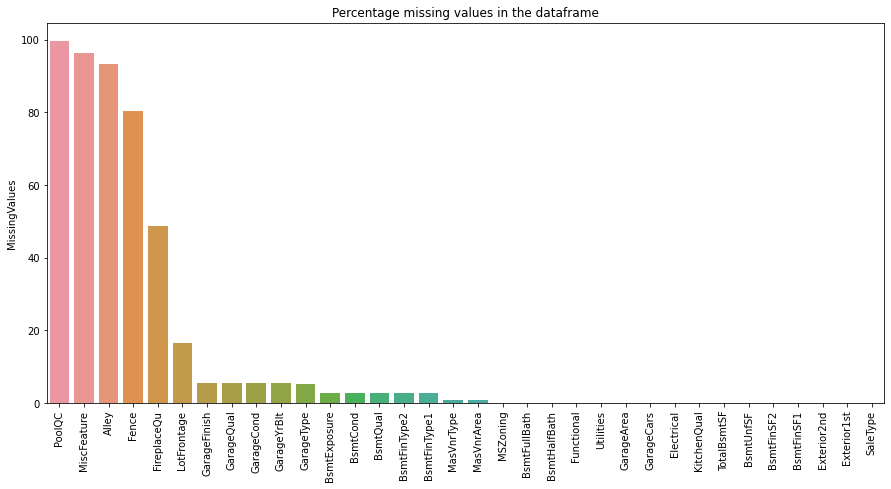

In [337]:
plt.figure(figsize=(15,7))
sns.barplot(x = missing_df.index, y = missing_df.MissingValues )
plt.xticks(rotation =90)
plt.title("Percentage missing values in the dataframe")

### Separating out the categorical features

In [338]:
combined_df.describe(include='object').T.sort_values(by=['count']).head(10)

,count,unique,top,freq
PoolQC,10,3,Ex,4
MiscFeature,105,4,Shed,95
Alley,198,2,Grvl,120
Fence,571,4,MnPrv,329
FireplaceQu,1499,5,Gd,744
GarageCond,2760,5,TA,2654
GarageQual,2760,5,TA,2604
GarageFinish,2760,3,Unf,1230
GarageType,2762,6,Attchd,1723
BsmtExposure,2837,4,No,1904


Checking the unique values in the categorical variables

In [339]:
category_col = ['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 'GarageFinish', 'GarageQual', 'GarageCond', 'GarageType', 'BsmtExposure', 'BsmtCond', 'BsmtQual', 'BsmtFinType2', 'BsmtFinType1', 'MasVnrType']
len(category_col)
for col in category_col:
    print('Unique values in ',col,': ',combined_df[col].unique())


Unique values in  PoolQC :  [nan 'Ex' 'Fa' 'Gd']
Unique values in  MiscFeature :  [nan 'Shed' 'Gar2' 'Othr' 'TenC']
Unique values in  Alley :  [nan 'Grvl' 'Pave']
Unique values in  Fence :  [nan 'MnPrv' 'GdWo' 'GdPrv' 'MnWw']
Unique values in  FireplaceQu :  [nan 'TA' 'Gd' 'Fa' 'Ex' 'Po']
Unique values in  GarageFinish :  ['RFn' 'Unf' 'Fin' nan]
Unique values in  GarageQual :  ['TA' 'Fa' 'Gd' nan 'Ex' 'Po']
Unique values in  GarageCond :  ['TA' 'Fa' nan 'Gd' 'Po' 'Ex']
Unique values in  GarageType :  ['Attchd' 'Detchd' 'BuiltIn' 'CarPort' nan 'Basment' '2Types']
Unique values in  BsmtExposure :  ['No' 'Gd' 'Mn' 'Av' nan]
Unique values in  BsmtCond :  ['TA' 'Gd' nan 'Fa' 'Po']
Unique values in  BsmtQual :  ['Gd' 'TA' 'Ex' nan 'Fa']
Unique values in  BsmtFinType2 :  ['Unf' 'BLQ' nan 'ALQ' 'Rec' 'LwQ' 'GLQ']
Unique values in  BsmtFinType1 :  ['GLQ' 'ALQ' 'Unf' 'Rec' 'BLQ' nan 'LwQ']
Unique values in  MasVnrType :  ['BrkFace' 'None' 'Stone' 'BrkCmn' nan]


We can observe from the data description that most of the categorical columns have NA values which can be used to fill the Nan values for the columns it makes sense. But in MasVnrType column we can see that there is None value as well as Nan value so for that we will use the mode function to fill the Na values in the column.

### Filling up the Nan values in the categorical columns

In [340]:
#removing the MasVnrType column from category col and storing it in new variable to fill na with the mode value
categorical_col_modeval = category_col.pop(-1)

for col in category_col:
    combined_df[col].fillna('NA', inplace=True)

In [341]:
print(combined_df['MasVnrType'].mode())
combined_df['MasVnrType'].fillna('None', inplace=True)

0    None
Name: MasVnrType, dtype: object


Dealing with the other categorical columns left

In [342]:
#Finding out the mode values and missing value count of other categorical columns
print('No of missing values in Eletrical: ', combined_df['Electrical'].isnull().sum(), '\t mode: ', combined_df['Electrical'].mode())
print('No of missing values in Utilities: ', combined_df['Utilities'].isnull().sum(), '\t mode: ', combined_df['Utilities'].mode())
print('No of missing values in Functional: ', combined_df['Functional'].isnull().sum(), '\t mode: ', combined_df['Functional'].mode())
print('No of missing values in SaleType: ', combined_df['SaleType'].isnull().sum(), '\t mode: ', combined_df['SaleType'].mode())
print('No of missing values in Exterior2nd: ', combined_df['Exterior2nd'].isnull().sum(), '\t mode: ', combined_df['Exterior2nd'].mode())
print('No of missing values in Exterior1st: ', combined_df['Exterior1st'].isnull().sum(), '\t mode: ', combined_df['Exterior1st'].mode())
print('No of missing values in KitchenQual: ', combined_df['KitchenQual'].isnull().sum(), '\t mode: ', combined_df['KitchenQual'].mode())
print('No of missing values in MSZoning: ', combined_df['MSZoning'].isnull().sum(), '\t mode: ',combined_df['MSZoning'].mode())


No of missing values in Eletrical:  1 	 mode:  0    SBrkr
Name: Electrical, dtype: object
No of missing values in Utilities:  2 	 mode:  0    AllPub
Name: Utilities, dtype: object
No of missing values in Functional:  2 	 mode:  0    Typ
Name: Functional, dtype: object
No of missing values in SaleType:  1 	 mode:  0    WD
Name: SaleType, dtype: object
No of missing values in Exterior2nd:  1 	 mode:  0    VinylSd
Name: Exterior2nd, dtype: object
No of missing values in Exterior1st:  1 	 mode:  0    VinylSd
Name: Exterior1st, dtype: object
No of missing values in KitchenQual:  1 	 mode:  0    TA
Name: KitchenQual, dtype: object
No of missing values in MSZoning:  4 	 mode:  0    RL
Name: MSZoning, dtype: object


In [343]:
#Filling up the Nan values with mode value of the above columns
combined_df['Electrical'].fillna('SBrkr', inplace=True)
combined_df['Utilities'].fillna('AllPub', inplace=True)
combined_df['Functional'].fillna('Typ', inplace=True)
combined_df['SaleType'].fillna('WD', inplace=True)
combined_df['Exterior2nd'].fillna('VinylSd', inplace=True)
combined_df['Exterior1st'].fillna('VinylSd', inplace=True)
combined_df['KitchenQual'].fillna('TA', inplace=True)
combined_df['MSZoning'].fillna('RL', inplace=True)

### Checking the the columns still left with null values

In [344]:
missing_df_v2 = calculate_missing_cols()
print(missing_df_v2)

              MissingValues
LotFrontage       16.649538
GarageYrBlt        5.447071
MasVnrArea         0.787941
BsmtFullBath       0.068517
BsmtHalfBath       0.068517
BsmtFinSF1         0.034258
BsmtFinSF2         0.034258
BsmtUnfSF          0.034258
TotalBsmtSF        0.034258
GarageCars         0.034258
GarageArea         0.034258


Text(0.5, 1.0, 'Percentage missing values in the dataframe')

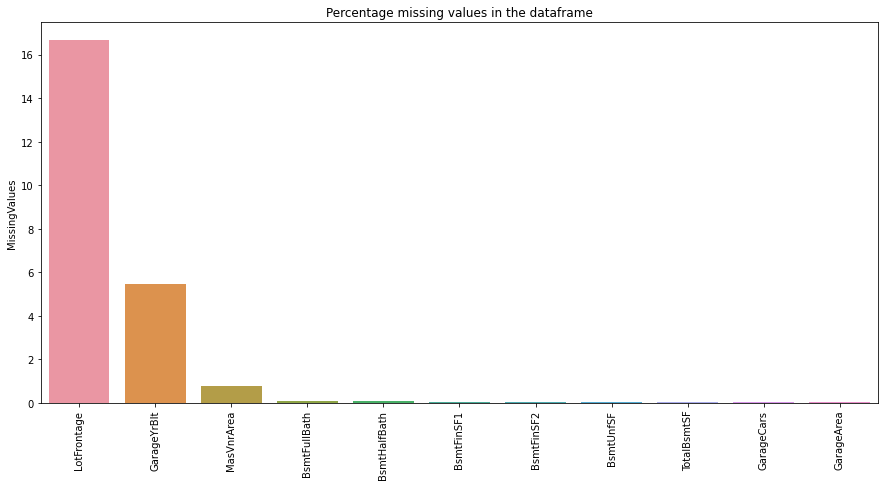

In [345]:
plt.figure(figsize=(15,7))
sns.barplot(x = missing_df_v2.index, y = missing_df_v2.MissingValues )
plt.xticks(rotation =90)
plt.title("Percentage missing values in the dataframe")

### Handling null values in the numerical columns

In [346]:
#using describe method to view the summary
combined_df.describe().T.sort_values(by='count').head(10)

,count,mean,std,min,25%,50%,75%,max
LotFrontage,2433.0,69.305795,23.344905,21.0,59.0,68.0,80.0,313.0
GarageYrBlt,2760.0,1978.113406,25.574285,1895.0,1960.0,1979.0,2002.0,2207.0
MasVnrArea,2896.0,102.201312,179.334253,0.0,0.0,0.0,164.0,1600.0
BsmtHalfBath,2917.0,0.061364,0.245687,0.0,0.0,0.0,0.0,2.0
BsmtFullBath,2917.0,0.429894,0.524736,0.0,0.0,0.0,1.0,3.0
GarageCars,2918.0,1.766621,0.761624,0.0,1.0,2.0,2.0,5.0
GarageArea,2918.0,472.874572,215.394815,0.0,320.0,480.0,576.0,1488.0
TotalBsmtSF,2918.0,1051.777587,440.766258,0.0,793.0,989.5,1302.0,6110.0
BsmtUnfSF,2918.0,560.772104,439.543659,0.0,220.0,467.0,805.5,2336.0
BsmtFinSF2,2918.0,49.582248,169.205611,0.0,0.0,0.0,0.0,1526.0


As we can observe from the above graph that LotFrontage have more than 17% of missing values. so we will use the mean of all the values to fill the null values.

In [347]:
#Handling null value for LotFrontage
print("No of missing values in :",combined_df['LotFrontage'].isnull().sum(), '\t mean: ', combined_df['LotFrontage'].mean())
combined_df['LotFrontage'].fillna(combined_df['LotFrontage'].mean(), inplace=True)

No of missing values in : 486 	 mean:  69.30579531442663


In [348]:
#Checking GarageType where GarageYrBlt is missing
combined_df[['GarageYrBlt','GarageType']].loc[combined_df.GarageYrBlt.isnull()]

,GarageYrBlt,GarageType
39,NaN,NA
48,NaN,NA
78,NaN,NA
88,NaN,NA
89,NaN,NA
...,...,...
2893,NaN,NA
2909,NaN,NA
2913,NaN,NA
2914,NaN,NA


As we can see the GarageYrBuilt is null for all GarageType as NA because the house doesn't have any garage, so it would not make sense to put the mean value of Garage Year built in place of null values so we will put 0 for all the null fields.

Similarly we will fill 0 for all the null value in GarageArea and GarageCars as these will also be 0 if a house doesn't hae any garages. 

In [349]:
combined_df['GarageYrBlt'].fillna(0, inplace=True)
combined_df['GarageArea'].fillna(0, inplace=True)
combined_df['GarageCars'].fillna(0, inplace=True)

For BsmtUnfSF also we will fill it 0 beacuse as per data description it denotes the unfinished surface area if basement but for house having no basement it should be 0.

In [350]:
print('No of missing values in BsmtUnfSF :', combined_df.BsmtUnfSF.isnull().sum())
combined_df['BsmtUnfSF'].fillna(0, inplace=True)

No of missing values in BsmtUnfSF : 1


Dealing with other null values and using mean to fill the null values

In [351]:
print('No of missing values in BsmtHalfBath :', combined_df.BsmtHalfBath.isnull().sum())
print('No of missing values in BsmtFullBath :', combined_df.BsmtFullBath.isnull().sum())
print('No of missing values in TotalBsmtSF :', combined_df.TotalBsmtSF.isnull().sum())
print('No of missing values in BsmtFinSF2 :', combined_df.BsmtFinSF2.isnull().sum())
print('No of missing values in BsmtFinSF1 :', combined_df.BsmtFinSF1.isnull().sum())
print('No of missing values in MasVnrArea :', combined_df.MasVnrArea.isnull().sum())

No of missing values in BsmtHalfBath : 2
No of missing values in BsmtFullBath : 2
No of missing values in TotalBsmtSF : 1
No of missing values in BsmtFinSF2 : 1
No of missing values in BsmtFinSF1 : 1
No of missing values in MasVnrArea : 23


In [352]:
#filling the null values with mean
combined_df['BsmtHalfBath'].fillna(combined_df.BsmtHalfBath.mean(), inplace=True)
combined_df['BsmtFullBath'].fillna(combined_df.BsmtFullBath.mean(), inplace=True)
combined_df['TotalBsmtSF'].fillna(combined_df.TotalBsmtSF.mean(), inplace=True)
combined_df['BsmtFinSF2'].fillna(combined_df.BsmtFinSF2.mean(), inplace=True)
combined_df['BsmtFinSF1'].fillna(combined_df.BsmtFinSF1.mean(), inplace=True)
combined_df['MasVnrArea'].fillna(combined_df.MasVnrArea.mean(), inplace=True)

In [353]:
combined_df.MSZoning.unique()

array(['RL', 'RM', 'C (all)', 'FV', 'RH'], dtype=object)

Checking if still any column left with null values

In [354]:
missing_df_v3 = calculate_missing_cols()
print(missing_df_v3)

Empty DataFrame
Columns: [MissingValues]
Index: []


## Mutual Information
We will use mutual information to select the features for predicting the target.

In [355]:
#creating copy of the dataframe
mi_X = combined_df[:1460].copy()
mi_y = target.copy()

#creating mutual information function to calculate the mi scores.
def calculate_mi_scores(X,y):
    for col in X.select_dtypes('object'):
        X[col],_ = X[col].factorize()
    
    #discrete_features= [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
    mi_scores = mutual_info_regression(X,y, random_state=0)
    mi_scores = pd.Series(mi_scores, name="MI_scores", index = X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)

    return mi_scores

In [356]:
mi_scores = calculate_mi_scores(mi_X, mi_y)
print(mi_scores.head(10))

OverallQual     0.562351
Neighborhood    0.494272
GrLivArea       0.484079
YearBuilt       0.370343
GarageCars      0.368134
TotalBsmtSF     0.366474
GarageArea      0.362922
KitchenQual     0.333339
ExterQual       0.327906
BsmtQual        0.320842
Name: MI_scores, dtype: float64


Text(0.5, 1.0, 'Mutual information scores')

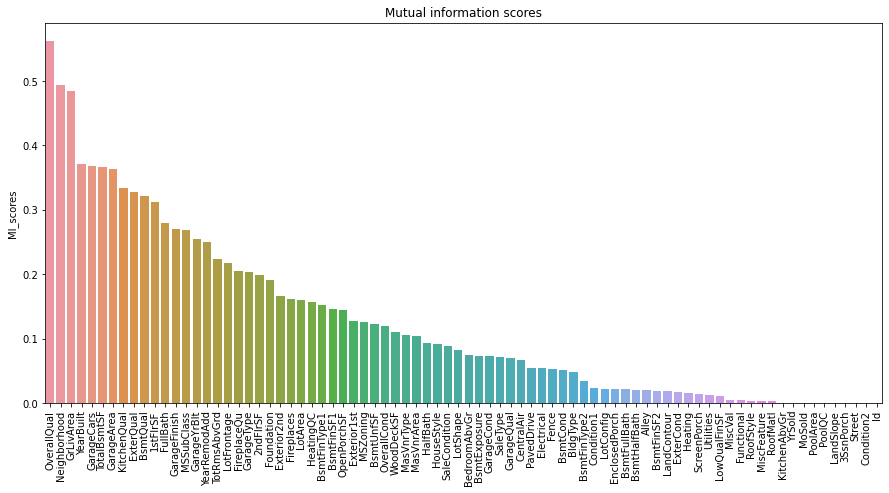

In [357]:
#plotting a graph to view the mi_scores
plt.figure(figsize=(15,7))
sns.barplot(x = mi_scores.index, y=mi_scores)
plt.xticks(rotation=90)
plt.title("Mutual information scores")

PLotting scatter plot to check the relation between the target value and the columns with high MI scores.

<AxesSubplot:xlabel='SalePrice', ylabel='MSSubClass'>

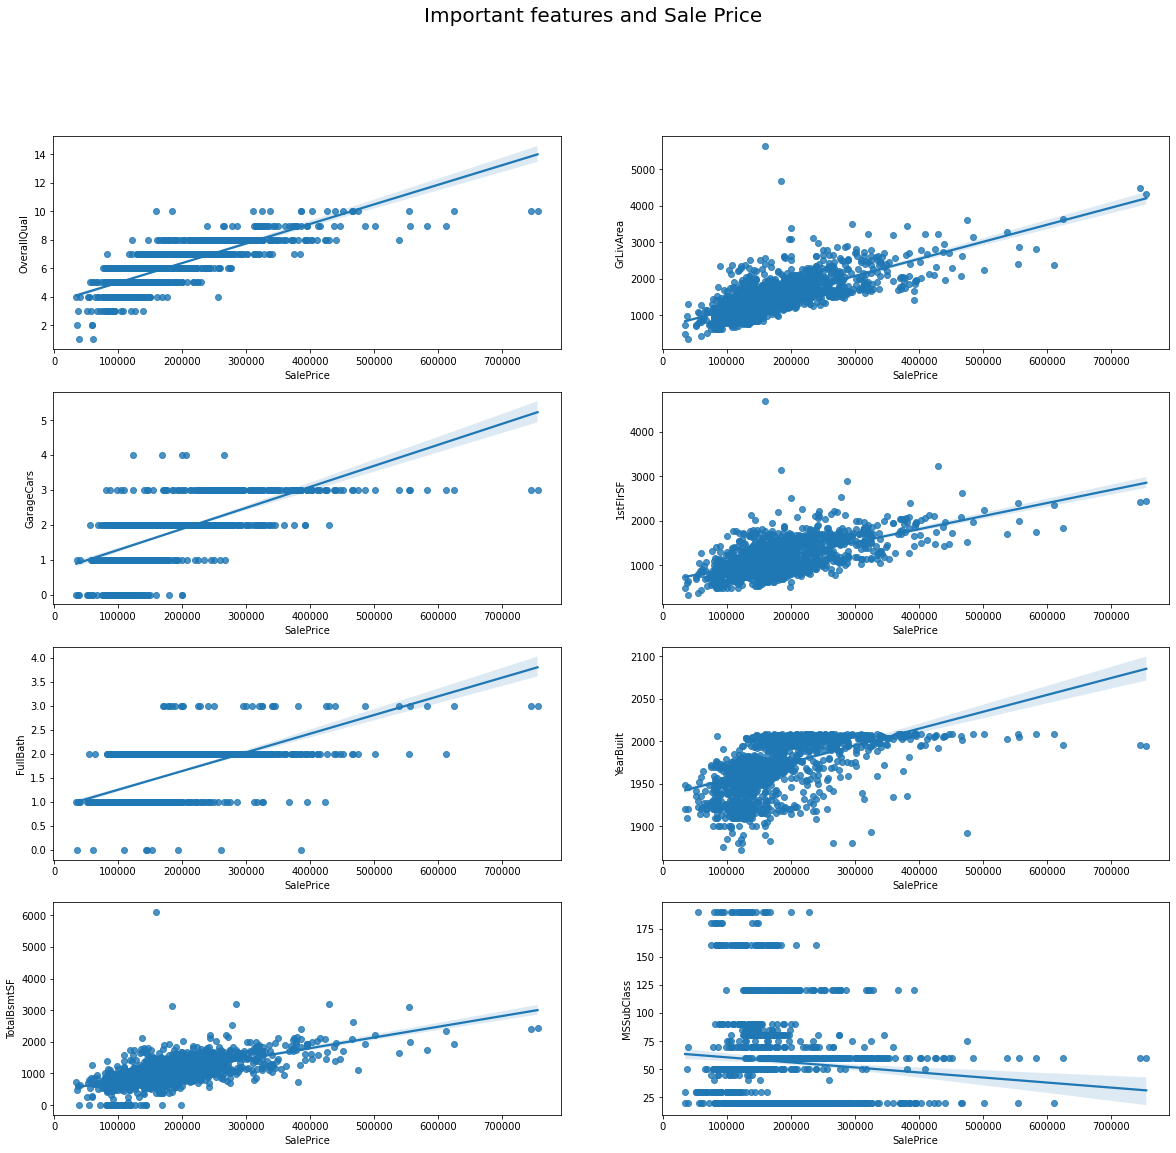

In [358]:
fig, ax = plt.subplots(4,2,figsize=(20,18))
fig.suptitle('Important features and Sale Price',size=20)
sns.regplot(x=target,y=combined_df[:1460]['OverallQual'],ax=ax[0,0])
sns.regplot(x=target,y=combined_df[:1460]['GrLivArea'],ax=ax[0,1])
sns.regplot(x=target,y=combined_df[:1460]['GarageCars'],ax=ax[1,0])
sns.regplot(x=target,y=combined_df[:1460]['1stFlrSF'],ax=ax[1,1])
sns.regplot(x=target,y=combined_df[:1460]['FullBath'],ax=ax[2,0])
sns.regplot(x=target,y=combined_df[:1460]['YearBuilt'],ax=ax[2,1])
sns.regplot(x=target, y=combined_df[:1460]['TotalBsmtSF'], ax= ax[3,0])
sns.regplot(x=target, y=combined_df[:1460]['MSSubClass'], ax= ax[3,1])

In [359]:
print(category_col)

['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 'GarageFinish', 'GarageQual', 'GarageCond', 'GarageType', 'BsmtExposure', 'BsmtCond', 'BsmtQual', 'BsmtFinType2', 'BsmtFinType1']


Feature Engineering and log transformation

In [360]:
combined_df_v2 = combined_df.copy()

In [361]:
combined_df_v2['GrLivArea'] = combined_df_v2['GrLivArea'].apply(np.log)
combined_df_v2['Log_1stFlrSF'] = combined_df_v2['1stFlrSF'].apply(np.log) 
combined_df_v2['Log_LotFrontage']= combined_df_v2['LotFrontage'].apply(np.log) 
combined_df_v2['Sqrt_LotArea']=combined_df_v2['LotArea'].apply(np.log)   
combined_df_v2['HouseAge']=combined_df_v2['YrSold']-combined_df_v2['YearBuilt']
combined_df_v2['Total_Rooms']= combined_df_v2['BedroomAbvGr'] + combined_df_v2['TotRmsAbvGrd']  
combined_df_v2['GrLivArea_Score']= np.sqrt(combined_df_v2['OverallQual']) * combined_df_v2['GrLivArea']
combined_df_v2['Total_Square_Feet'] = combined_df_v2.TotalBsmtSF + combined_df_v2['1stFlrSF'] + combined_df_v2['2ndFlrSF']
combined_df_v2['Total_Porch'] = combined_df_v2.ScreenPorch + combined_df_v2.EnclosedPorch + combined_df_v2.OpenPorchSF + combined_df_v2.WoodDeckSF + combined_df_v2['3SsnPorch']
combined_df_v2['OverallQualCond'] = (combined_df_v2['OverallCond'] * combined_df_v2.OverallQual)
combined_df_v2['BsmtFinSF']=combined_df_v2['BsmtFinSF1'] + combined_df_v2['BsmtFinSF2'] 
combined_df_v2['TotalBath_Abv']=2*combined_df_v2['FullBath']+combined_df_v2['HalfBath']*0.5
combined_df_v2['TotalBath_Bsmt']=2*combined_df_v2['BsmtFullBath']+combined_df_v2['BsmtHalfBath']*0.5

In [362]:
target = target.apply(np.log)

Applying ordinal encoding to categorical columns

In [363]:
#storing all categorical columns at one place to apply ordinal enoder or onehot encoder
cat_col = []
for col in combined_df.columns:
    if combined_df[col].dtype =='object':
        cat_col.append(col)


In [364]:
#separating columns for ONe-hot encoding
# OH_cols=[]
# for col in cat_col:
#     if len(combined_df[col].unique())<10:
#         OH_cols.append(col)

# #separating columns for ordinal encoding
# ord_cols = list(set(cat_col) - set(OH_cols))

In [365]:
#creating a copy of data to perform ordinal and one hot encoding


Performing Ordinal encoding on the columns which has more than 10 categorical values

In [366]:
ordinal_encoder = OrdinalEncoder()
ordinal_df = ordinal_encoder.fit_transform(combined_df_v2[cat_col])

ordinal_df = pd.DataFrame(ordinal_df, index = combined_df_v2.index ,columns = cat_col)

In [367]:
print(ordinal_df.head(10))

   MSZoning  Street  Alley  LotShape  LandContour  Utilities  LotConfig  \
0       3.0     1.0    1.0       3.0          3.0        0.0        4.0   
1       3.0     1.0    1.0       3.0          3.0        0.0        2.0   
2       3.0     1.0    1.0       0.0          3.0        0.0        4.0   
3       3.0     1.0    1.0       0.0          3.0        0.0        0.0   
4       3.0     1.0    1.0       0.0          3.0        0.0        2.0   
5       3.0     1.0    1.0       0.0          3.0        0.0        4.0   
6       3.0     1.0    1.0       3.0          3.0        0.0        4.0   
7       3.0     1.0    1.0       0.0          3.0        0.0        0.0   
8       4.0     1.0    1.0       3.0          3.0        0.0        4.0   
9       3.0     1.0    1.0       3.0          3.0        0.0        0.0   

   LandSlope  Neighborhood  Condition1  ...  GarageType  GarageFinish  \
0        0.0           5.0         2.0  ...         1.0           2.0   
1        0.0          24.0  

In [368]:
#dropping the ordianl categorical columns from our main dataset
combined_df_v2 = combined_df_v2.drop(cat_col, axis=1)


In [369]:
#adding the ordinally encoded columns back to the dataframe
combined_df_v2 = pd.concat([combined_df_v2, ordinal_df], axis=1)

combined_df_v2.head()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
0,1,60,65.0,8450,7,5,2003,2003,196.0,706.0,...,1.0,2.0,5.0,5.0,2.0,3.0,4.0,1.0,8.0,4.0
1,2,20,80.0,9600,6,8,1976,1976,0.0,978.0,...,1.0,2.0,5.0,5.0,2.0,3.0,4.0,1.0,8.0,4.0
2,3,60,68.0,11250,7,5,2001,2002,162.0,486.0,...,1.0,2.0,5.0,5.0,2.0,3.0,4.0,1.0,8.0,4.0
3,4,70,60.0,9550,7,5,1915,1970,0.0,216.0,...,5.0,3.0,5.0,5.0,2.0,3.0,4.0,1.0,8.0,0.0
4,5,60,84.0,14260,8,5,2000,2000,350.0,655.0,...,1.0,2.0,5.0,5.0,2.0,3.0,4.0,1.0,8.0,4.0


Performing One hot encoding on the column which has less than 10 categorical values

In [370]:
# OH_encoder = OneHotEncoder()
# OH_df = OH_encoder.fit_transform(combined_df_v2[OH_cols])

# OH_df = pd.DataFrame(OH_df, columns= OH_encoder.categories_)
# print(OH_df)

In [371]:
# print(len(OH_cols))

Splitting data into train and test 

In [372]:
#dropping the index columns
combined_df_v2.drop('Id', axis=1, inplace=True)

#splitting the data after encoding
train_df = combined_df_v2[:1460].copy()
train_df['SalePrice'] = target
test_df = combined_df_v2[1460:].copy()

## Removing outliers from train dataset for better predictions

We will be calculating the Z score 
Z score = (x-mean)/std dev


In [373]:
#columns for z score calculation
numeric_columns_z = train_df.columns

z = np.abs(stats.zscore(train_df[numeric_columns_z]))

In [374]:
train_df_z = train_df.copy()[(z<10).all(axis=1)]

print('Rows with outlier',train_df.shape)
print('Rows witout outliers', train_df_z.shape)

Rows with outlier (1460, 92)
Rows witout outliers (1422, 92)


Declaring features that we will use for prediction

In [375]:
#features = ['OverallQual', 'Neighborhood', 'GrLivArea', 'YearBuilt', 'GarageCars', 'TotalBsmtSF', 'GarageArea',
            #   'KitchenQual', 'ExterQual', 'BsmtQual','1stFlrSF','FullBath','GarageYrBlt',
            #   'YearRemodAdd', 'TotRmsAbvGrd','LotFrontage','FireplaceQu', 'GarageType','2ndFlrSF', 'Foundation',
            #   'Exterior2nd','Fireplaces','LotArea','HeatingQC','BsmtFinType1','OpenPorchSF','Exterior1st','MSZoning',
            #   'BsmtUnfSF','OverallCond','WoodDeckSF','MasVnrType','MasVnrArea', 'HalfBath', 'HouseStyle','SaleCondition',
            #   'LotShape', 'BedroomAbvGr','BsmtExposure','SaleType']

features = ['GrLivArea', 'Log_1stFlrSF', 'Log_LotFrontage', 'Sqrt_LotArea','HouseAge',
'Total_Rooms','GrLivArea_Score','Total_Square_Feet','Total_Porch','OverallQualCond',
'BsmtFinSF','TotalBath_Abv','TotalBath_Bsmt',
'Neighborhood', 'GarageCars','GarageArea', 'KitchenQual','FireplaceQu','MasVnrType','MasVnrArea','SaleCondition',
'SaleType']

X = train_df_z[features]
y = train_df_z['SalePrice']

scaler=StandardScaler()
X_scaled=scaler.fit_transform(X)

In [376]:
#splitting the data into train and valid to test the prediction scores
X_train, X_valid, y_train, y_valid = train_test_split(X_scaled,y, test_size=0.30, random_state=5)

DEfining score functions to evaluate our predictions

In [377]:
# evaluate a given model by making predictions on X_valid
def get_v_score(model):
    valid_predictions=model.predict(X_valid)
    score=np.sqrt(mean_squared_error(y_valid, valid_predictions))
    return score

# evaluate a given model using cross-validation
def get_cv_score(model, X, y):
    #cv = KFold(n_splits=5, shuffle=True, random_state=1)
    scores = np.sqrt(-cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=5, n_jobs=-1))
    return np.mean(scores)

Predicting values using RandomForestRegressor

In [378]:
model_RandomForestRegressor = RandomForestRegressor(random_state=1, n_estimators=250)

model_RandomForestRegressor.fit(X_train, y_train)

RFR_pred = model_RandomForestRegressor.predict(X_valid)


In [379]:
RFR_mse_score = get_v_score(model_RandomForestRegressor)
print("Random Forest Regressor mean squared error score: ",RFR_mse_score)
RFR_cvs_score = get_cv_score(model_RandomForestRegressor,X,y)
print("Random Forest Regressor cross validation score: ",RFR_cvs_score)

Random Forest Regressor mean squared error score:  0.15263135668065747
Random Forest Regressor cross validation score:  0.1374456890951613


In [380]:
model_XGBregressor = XGBRegressor()
model_XGBregressor.fit(X_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [381]:
XGB_mse_score = get_v_score(model_XGBregressor)
print(XGB_mse_score)
XGB_cvs_score = get_cv_score(model_XGBregressor,X,y)
print(XGB_cvs_score)

0.15967545133406427
0.13922747952822617


In [382]:
model_GBoost = GradientBoostingRegressor(n_estimators=500, learning_rate=0.05)
model_GBoost.fit(X_train, y_train)
GB_predict = model_GBoost.predict(X_valid)

In [383]:
GB_mse_score = get_v_score(model_GBoost)
print(GB_mse_score)
GB_cvs_score = get_cv_score(model_GBoost,X,y)
print(GB_cvs_score)

0.14134171983820995
0.12610774205450292


<AxesSubplot:xlabel='SalePrice'>

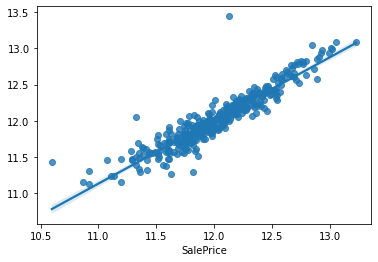

In [384]:
sns.regplot(x= y_valid, y= GB_predict)

In [385]:
print(len(GB_predict))
test_df_scaled = scaler.transform(test_df[features])
test_df_preds = model_GBoost.predict(test_df_scaled)


427


In [387]:
test_preds=pd.DataFrame({'Id':test['Id'],'SalePrice':(np.exp(test_df_preds))})

In [389]:
test_preds.to_csv('submission_v1.csv', index=False)